# Skin Disease Pytorch Lightning CNN

In [9]:
!pip install pytorch-lightning


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [10]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [11]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [12]:
import os

# List top-level directories in /kaggle/input
input_base_path = "/kaggle/input"
print(os.listdir(input_base_path))


['Skin Cancer Dataset']


In [13]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os

# Correct path to the dataset
dataset_path = "/kaggle/input/Skin Cancer Dataset"

# Ensure the path is correct by listing contents (optional)
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"The directory {dataset_path} does not exist")

# Initialize the dataset with transformations if needed
dataset0 = datasets.ImageFolder(root=dataset_path, transform=None)

# Get class names and their count
class_names = dataset0.classes
print("Class Names:", class_names)
print("Number of Classes:", len(class_names))


Class Names: ['Acitinic Keratosis', 'Basal Cell Carcinoma', 'Dermatofibroma', 'Melanoma', 'Nevus', 'Pigmented Benign Keratosis', 'Seborrheic Keratosis', 'Squamous Cell Carcinoma', 'Vascular Lesion']
Number of Classes: 9


In [14]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

# Define the DataModule class
class DataModule(pl.LightningDataModule):
    def __init__(self, transform=None, batch_size=32, image_size=(224, 224)):
        super().__init__()
        self.root_dir = "/kaggle/input/Skin Cancer Dataset"
        self.image_size = image_size
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor()
        ])
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train

        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size, num_workers=4)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset

# Define the ConvolutionalNetwork class
class ConvolutionalNetwork(pl.LightningModule):
    def __init__(self, num_classes):
        super(ConvolutionalNetwork, self).__init__()
        
        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # Define fully connected layers
        self.fc1 = nn.Linear(32 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, X):
        # Pass through convolutional layers
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        
        # Print tensor shape after convolution and pooling
        print("Shape after conv2 and pooling:", X.shape)
        
        # Flatten the tensor to feed into fully connected layers
        X = X.view(X.size(0), -1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        return loss

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# Instantiate the DataModule
datamodule = DataModule(batch_size=32, image_size=(224, 224))

# Instantiate the model
num_classes = 9
model = ConvolutionalNetwork(num_classes=num_classes)

# Instantiate the PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=100, accelerator='auto', devices=1)

# Train and test the model
trainer.fit(model, datamodule)
trainer.test(dataloaders=datamodule.test_dataloader())


GPU available: False, used: False
TPU available: True, using: 1 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | conv1 | Conv2d | 448    | train
1 | conv2 | Conv2d | 4.6 K  | train
2 | fc1   | Linear | 25.7 M | train
3 | fc2   | Linear | 16.4 K | train
4 | fc3   | Linear | 585    | train
-----------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.850   Total estimated model params size (MB)


Epoch 99: 100%|██████████| 103/103 [00:39<00:00,  2.59it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 103/103 [00:40<00:00,  2.52it/s, v_num=1]


/usr/local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_1/checkpoints/epoch=99-step=10300.ckpt
Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_1/checkpoints/epoch=99-step=10300.ckpt


Testing DataLoader 0: 100%|██████████| 26/26 [00:29<00:00,  0.88it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4720194637775421     │
│         test_loss         │    5.3876237869262695     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.3876237869262695, 'test_acc': 0.4720194637775421}]

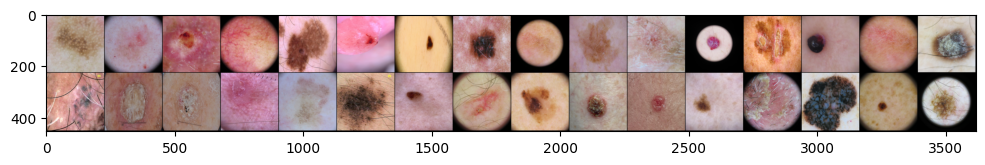

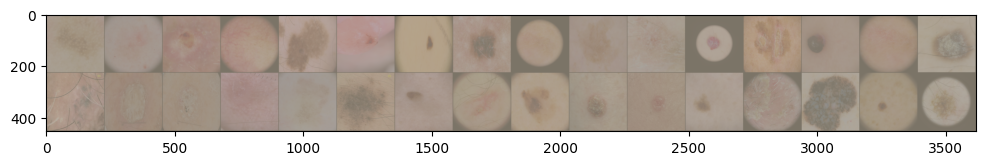

In [15]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [16]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Size([32, 32, 56, 56])
Shape after conv2 and pooling: torch.Siz

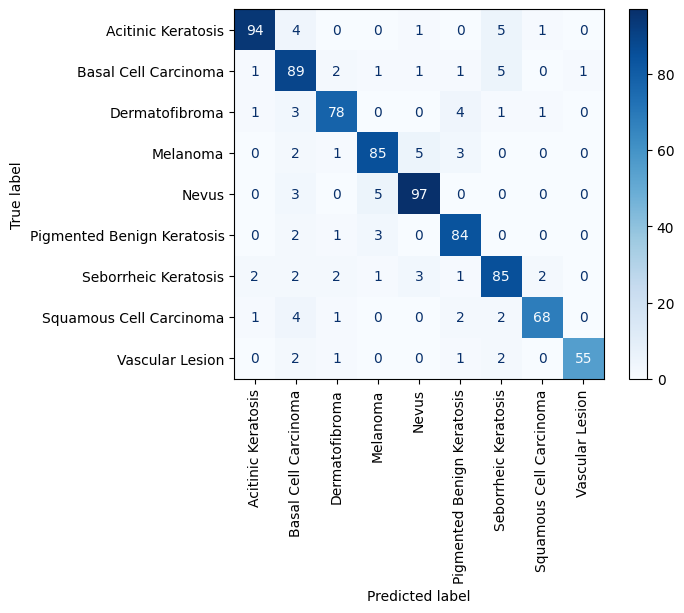

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [18]:
torch.save(model.state_dict(), "convolutional_network.pth")